**Nama : Wilianto, S.T., S.Pd., M.M, M.T.I.**

>Dataset : "Movie Genre Data"\
>Sumber : Kaggle\
>Link Dataset : https://www.kaggle.com/lokkagle/nlp-movie-genre-classification/data


Libraries

In [74]:
from google.colab import drive

# u/ dataframe
import pandas as pd
import re

# u/ split data
from sklearn.model_selection import train_test_split

# u/ preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# u/ visualisasi plot
import matplotlib.pyplot as plt

Mount ke Drive

In [75]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Read Dataset dari Drive

In [76]:
df = pd.read_csv("/content/drive/MyDrive/Dicoding/kaggle_movie_train.csv")
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


Memeriksa jumlah value tiap genre

In [77]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

Kita akan menggunakan 4 genre saja kali ini yaitu: comedy, action, horror, dan adventure

In [78]:
# Menghapus genre selain 4 genre tersebut
df = df[~df['genre'].isin(['drama','thriller','sci-fi','other','romance'])]
df['genre'].value_counts()

comedy       2941
action       2392
horror        456
adventure     147
Name: genre, dtype: int64

Proses awal text kolom

In [79]:
# Menghapus special character di kolom text
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom text lama
df = df.drop(['id','text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


Pemeriksaan data kosong

In [80]:
# Mememriksa nilai kosong / nan
# Jika true maka ada dan jika false maka tidak ada nilai kosong / nan
df.isnull().values.any()

False

Pelabelan genre

In [81]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,Text,action,adventure,comedy,horror
1,t summa cum laude and all And I m about to lau...,0,0,1,0
9,e reels as the world spins Sweat pours off him...,1,0,0,0
20,I say he s a man who ll go far Some people sa...,0,0,1,0
25,you find out where the bachelor party is COLE ...,0,0,1,0
29,ibly horrendous public break up on the quad Ag...,0,0,1,0


Merubah tipe data

In [82]:
# Merubah tipe data menjadi str dan numpy array 
text = df_genre['Text'].astype(str)
label = df_genre[['comedy', 'action','horror','adventure']].values

Split dataset menjadi 20% validation/test

In [83]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

Penggunaan tokenizer

In [84]:
# Konversi ke sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

Pemodelan Sequential dengan Embedding dan LSTM

In [85]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

Model compile dengan optimizer Adam

In [86]:
#Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          80000     
                                                                 
 lstm_4 (LSTM)               (None, 64)                20736     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 109,572
Trainable params: 109,572
Non-trainable params: 0
_________________________________________________________________


Penggunaan callback untuk accuracy dan validation diatas 90%

In [87]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

Melatih model

In [88]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
149/149 - 24s - loss: 1.0384 - accuracy: 0.4777 - val_loss: 1.0119 - val_accuracy: 0.4756 - 24s/epoch - 161ms/step
Epoch 2/30
149/149 - 22s - loss: 0.8482 - accuracy: 0.5729 - val_loss: 0.8019 - val_accuracy: 0.5648 - 22s/epoch - 145ms/step
Epoch 3/30
149/149 - 21s - loss: 0.4587 - accuracy: 0.8275 - val_loss: 0.4734 - val_accuracy: 0.8089 - 21s/epoch - 144ms/step
Epoch 4/30
149/149 - 22s - loss: 0.2601 - accuracy: 0.9130 - val_loss: 0.3799 - val_accuracy: 0.8670 - 22s/epoch - 145ms/step
Epoch 5/30
149/149 - 22s - loss: 0.1808 - accuracy: 0.9387 - val_loss: 0.4815 - val_accuracy: 0.8434 - 22s/epoch - 145ms/step
Epoch 6/30
149/149 - 21s - loss: 0.1388 - accuracy: 0.9520 - val_loss: 0.3523 - val_accuracy: 0.8864 - 21s/epoch - 142ms/step
Epoch 7/30
149/149 - 21s - loss: 0.0812 - accuracy: 0.9695 - val_loss: 0.3528 - val_accuracy: 0.8914 - 21s/epoch - 144ms/step
Epoch 8/30
149/149 - 21s - loss: 0.0592 - accuracy: 0.9779 - val_loss: 0.5505 - val_accuracy: 0.8822 - 21s/epoch - 143

Membuat plot loss

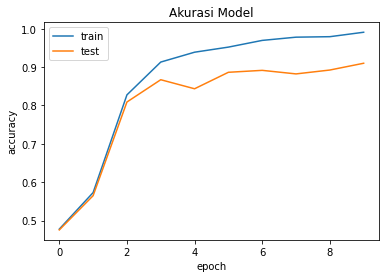

In [89]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Membuat plot accuracy

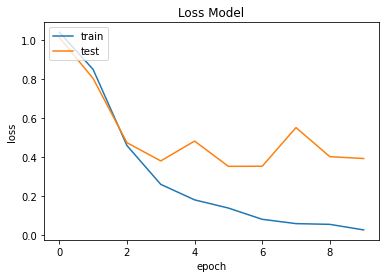

In [90]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()